In [80]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

In [81]:

# Spark Session oluşturma
spark = SparkSession.builder.appName('project').getOrCreate()

# CSV dosyasını Spark DataFrame'e yükleme
data = spark.read.csv('data.csv', header=True, inferSchema=True)

# Veri setini gösterme
data.show()




+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|battery_power|blue|clock_speed|dual_sim| fc|four_g|int_memory|m_dep|mobile_wt|n_cores| pc|px_height|px_width| ram|sc_h|sc_w|talk_time|three_g|touch_screen|wifi|price_range|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|          842|   0|        2.2|       0|  1|     0|         7|  0.6|      188|      2|  2|       20|     756|2549|   9|   7|       19|      0|           0|   1|          1|
|         1021|   1|        0.5|       1|  0|     1|        53|  0.7|      136|      3|  6|      905|    1988|2631|  17|   3|        7|      1|           1|   0|          2|
|          563|   1|        0.5|       1|  2|     1|        41|  0.9|      145|      5|  6|     1263|    1716|2603|  11|   2|     

In [82]:


def DataInfo(dataframe, head=5):
    # Dataframe'in ilk kısmını gösterme
    print("################## Dataframe Head ##################")
    dataframe.show(head)
    
    # Dataframe'in yapısal bilgilerini gösterme
    print("################## Dataframe Schema ##################")
    dataframe.printSchema()
    
    # Dataframe'in istatistiksel özetini gösterme
    print("################## Dataframe Summary ##################")
    dataframe.describe().show()
    
    # Dataframe'in sütunlarını gösterme
    print("################## Dataframe Columns ##################")
    print(dataframe.columns)
    
    # Dataframe'in satır ve sütun sayısını gösterme
    print("################## Dataframe Shape ##################")
    print((dataframe.count(), len(dataframe.columns)))
    
    # Eksik değer sayısını gösterme
    print("################## Isnull sum() ##################")
    for col in dataframe.columns:
        print(col, ":", dataframe.filter(dataframe[col].isNull()).count())

# Fonksiyonu çağırma
DataInfo(data)

################## Dataframe Head ##################
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|battery_power|blue|clock_speed|dual_sim| fc|four_g|int_memory|m_dep|mobile_wt|n_cores| pc|px_height|px_width| ram|sc_h|sc_w|talk_time|three_g|touch_screen|wifi|price_range|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|          842|   0|        2.2|       0|  1|     0|         7|  0.6|      188|      2|  2|       20|     756|2549|   9|   7|       19|      0|           0|   1|          1|
|         1021|   1|        0.5|       1|  0|     1|        53|  0.7|      136|      3|  6|      905|    1988|2631|  17|   3|        7|      1|           1|   0|          2|
|          563|   1|        0.5|       1|  2|     1|        41|  0.9|      14

In [83]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # Kategorik sütunları toplama
    cat_cols = [col for col in dataframe.columns if dataframe.select(col).distinct().count() < cat_th]
    
    # Sayısal ancak kategorik sütunları toplama
    num_but_cat = [col for col in dataframe.columns if (dataframe.select(col).distinct().count() < cat_th) and (dataframe.select(col).dtypes != 'string')]
    
    # Kategorik ancak sayısal sütunları toplama
    cat_but_car = [col for col in dataframe.columns if (dataframe.select(col).distinct().count() > car_th) and (dataframe.select(col).dtypes == 'string')]
    
    # Kategorik sütunları birleştirme
    cat_cols = list(set(num_but_cat + cat_cols))
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    # Sayısal sütunları toplama
    num_cols = [col for col in dataframe.columns if col not in cat_cols and col not in cat_but_car]
    
    print(f"Observations: {dataframe.count()}")
    print(f"Variables: {len(dataframe.columns)}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols,num_cols,cat_but_car =grab_col_names(data)

Observations: 2000
Variables: 21
cat_cols: 8
num_cols: 13
cat_but_car: 0
num_but_cat: 8


In [84]:
cat_cols

['four_g',
 'wifi',
 'three_g',
 'blue',
 'n_cores',
 'touch_screen',
 'dual_sim',
 'price_range']

In [85]:
num_cols

['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time']

In [86]:
#kategorik değişken analizi
def cat_summary(dataframe, col_name):
    # Sütun için değer sayılarını ve oranlarını hesaplama
    col_counts = dataframe.groupBy(col_name).count()
    
    # Verileri gösterme
    col_counts.show()

for col in cat_cols:
    cat_summary(data,col)
    

+------+-----+
|four_g|count|
+------+-----+
|     1| 1043|
|     0|  957|
+------+-----+

+----+-----+
|wifi|count|
+----+-----+
|   1| 1014|
|   0|  986|
+----+-----+

+-------+-----+
|three_g|count|
+-------+-----+
|      1| 1523|
|      0|  477|
+-------+-----+

+----+-----+
|blue|count|
+----+-----+
|   1|  990|
|   0| 1010|
+----+-----+

+-------+-----+
|n_cores|count|
+-------+-----+
|      1|  242|
|      6|  230|
|      3|  246|
|      5|  246|
|      4|  274|
|      8|  256|
|      7|  259|
|      2|  247|
+-------+-----+

+------------+-----+
|touch_screen|count|
+------------+-----+
|           1| 1006|
|           0|  994|
+------------+-----+

+--------+-----+
|dual_sim|count|
+--------+-----+
|       1| 1019|
|       0|  981|
+--------+-----+

+-----------+-----+
|price_range|count|
+-----------+-----+
|          1|  500|
|          3|  500|
|          2|  500|
|          0|  500|
+-----------+-----+



+-------+-----------------+
|summary|    battery_power|
+-------+-----------------+
|  count|             2000|
|   mean|        1238.5185|
| stddev|439.4182060835313|
|    min|              501|
|    max|             1998|
+-------+-----------------+



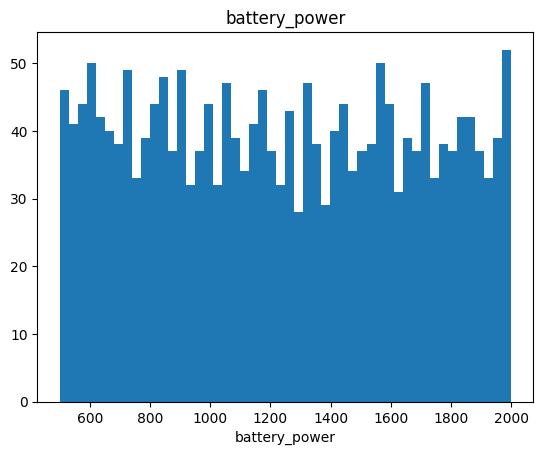

#####################################
+-------+------------------+
|summary|       clock_speed|
+-------+------------------+
|  count|              2000|
|   mean|1.5222499999999983|
| stddev| 0.816004208895068|
|    min|               0.5|
|    max|               3.0|
+-------+------------------+



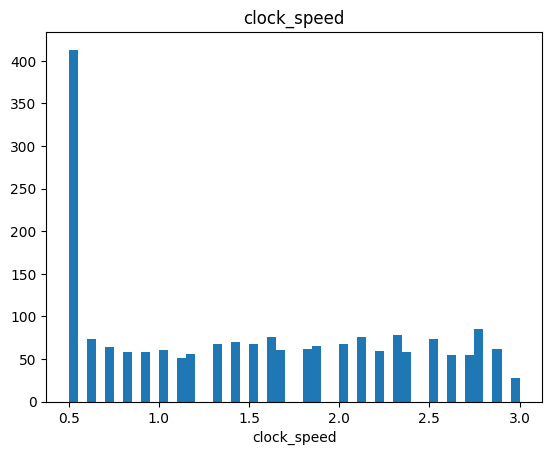

#####################################
+-------+-----------------+
|summary|               fc|
+-------+-----------------+
|  count|             2000|
|   mean|           4.3095|
| stddev|4.341443747983898|
|    min|                0|
|    max|               19|
+-------+-----------------+



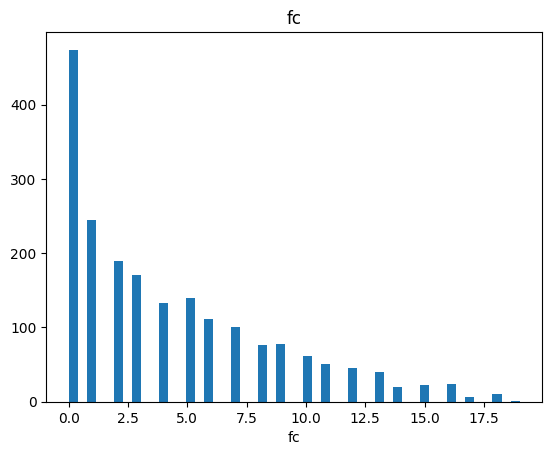

#####################################
+-------+------------------+
|summary|        int_memory|
+-------+------------------+
|  count|              2000|
|   mean|           32.0465|
| stddev|18.145714955206856|
|    min|                 2|
|    max|                64|
+-------+------------------+



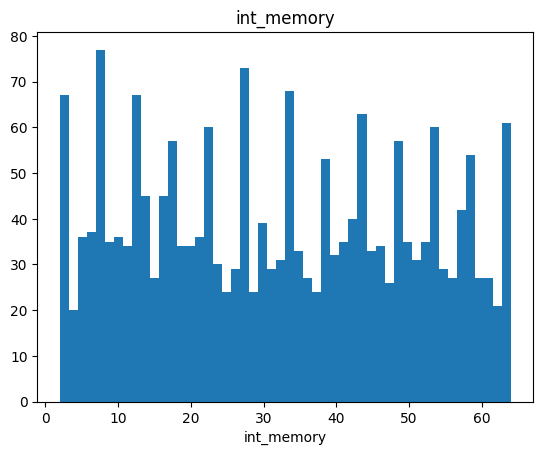

#####################################
+-------+------------------+
|summary|             m_dep|
+-------+------------------+
|  count|              2000|
|   mean|0.5017500000000017|
| stddev|0.2884155496235117|
|    min|               0.1|
|    max|               1.0|
+-------+------------------+



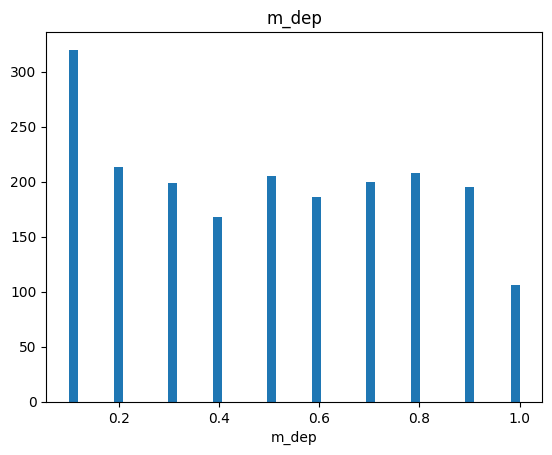

#####################################
+-------+-----------------+
|summary|        mobile_wt|
+-------+-----------------+
|  count|             2000|
|   mean|          140.249|
| stddev|35.39965489638834|
|    min|               80|
|    max|              200|
+-------+-----------------+



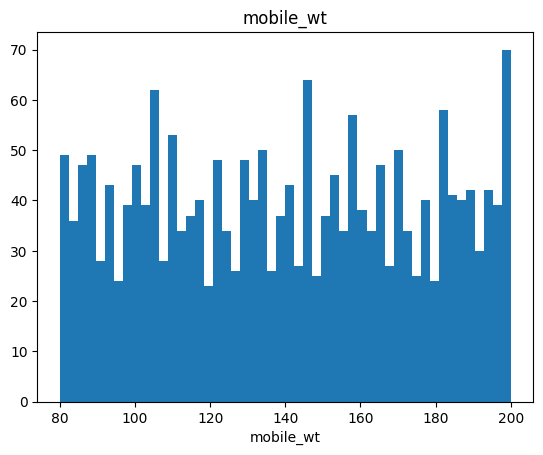

#####################################
+-------+-----------------+
|summary|               pc|
+-------+-----------------+
|  count|             2000|
|   mean|           9.9165|
| stddev|6.064314941347778|
|    min|                0|
|    max|               20|
+-------+-----------------+



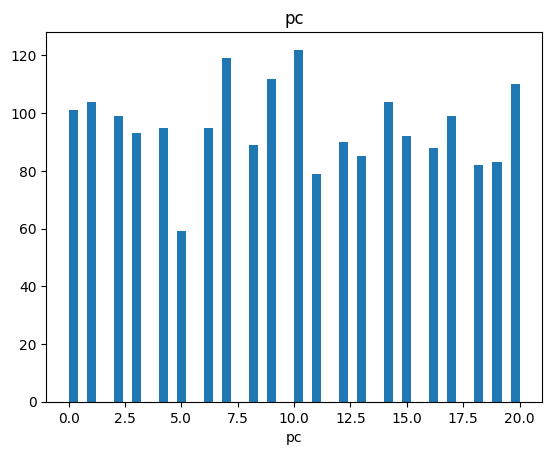

#####################################
+-------+------------------+
|summary|         px_height|
+-------+------------------+
|  count|              2000|
|   mean|           645.108|
| stddev|443.78081080643824|
|    min|                 0|
|    max|              1960|
+-------+------------------+



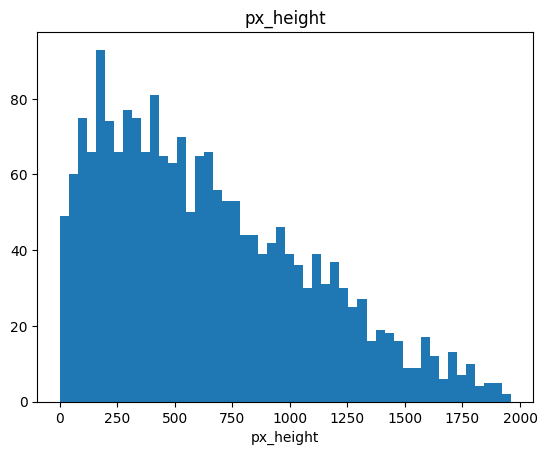

#####################################
+-------+-----------------+
|summary|         px_width|
+-------+-----------------+
|  count|             2000|
|   mean|        1251.5155|
| stddev|432.1994469463379|
|    min|              500|
|    max|             1998|
+-------+-----------------+



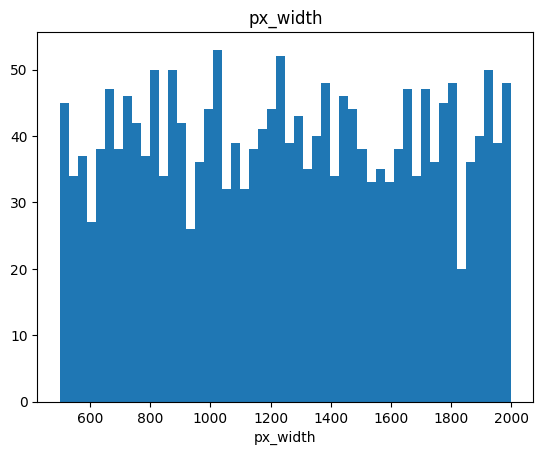

#####################################
+-------+------------------+
|summary|               ram|
+-------+------------------+
|  count|              2000|
|   mean|          2124.213|
| stddev|1084.7320436099492|
|    min|               256|
|    max|              3998|
+-------+------------------+



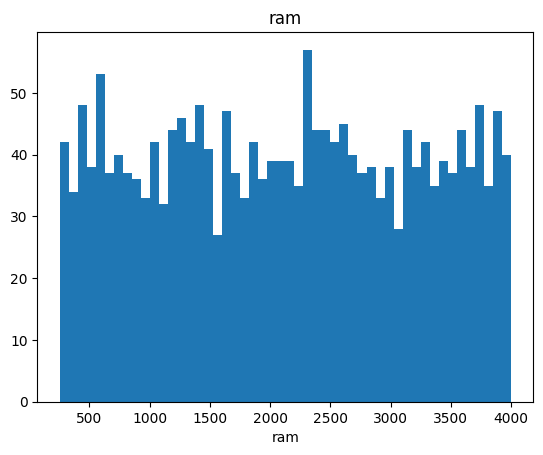

#####################################
+-------+-----------------+
|summary|             sc_h|
+-------+-----------------+
|  count|             2000|
|   mean|          12.3065|
| stddev|4.213245004356303|
|    min|                5|
|    max|               19|
+-------+-----------------+



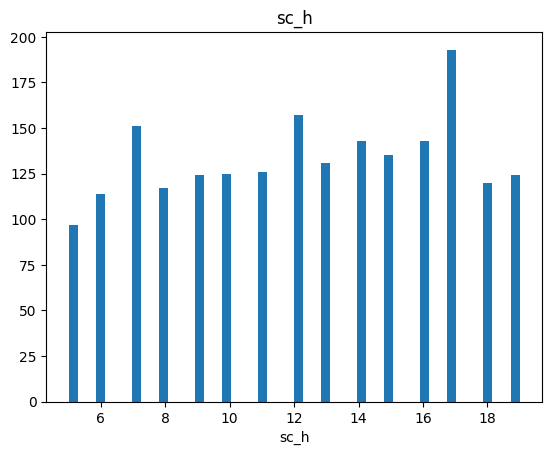

#####################################
+-------+-----------------+
|summary|             sc_w|
+-------+-----------------+
|  count|             2000|
|   mean|            5.767|
| stddev|4.356397605826408|
|    min|                0|
|    max|               18|
+-------+-----------------+



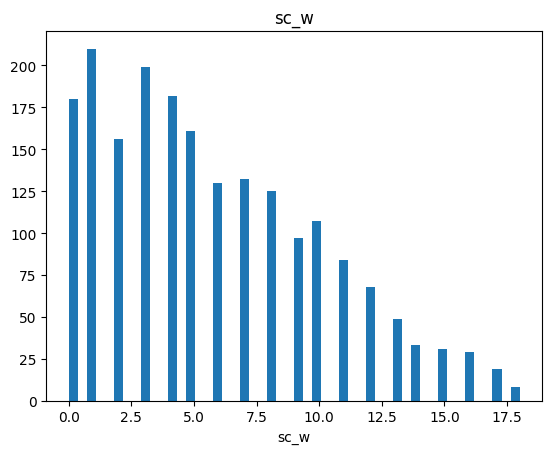

#####################################
+-------+-----------------+
|summary|        talk_time|
+-------+-----------------+
|  count|             2000|
|   mean|           11.011|
| stddev|5.463955197766688|
|    min|                2|
|    max|               20|
+-------+-----------------+



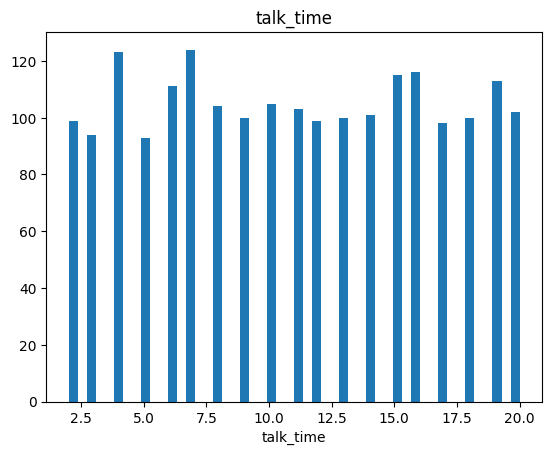

#####################################


In [87]:
#numeric değişken analizi

def num_summary(dataframe, col):
    summary = dataframe.select(col).describe()
    summary.show()
    
    pandas_df = dataframe.select(col).toPandas()
    plt.hist(pandas_df[col], bins=50)
    plt.xlabel(col)
    plt.title(col)
    plt.show()
    
    print("#####################################")

for col in num_cols:
    num_summary(data,col)

In [88]:
#aykiri deger analizi
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [89]:
pandas_df = data.toPandas()
for col in num_cols:
    print(col, check_outlier(pandas_df, col))

battery_power False
clock_speed False
fc False
int_memory False
m_dep False
mobile_wt False
pc False
px_height False
px_width False
ram False
sc_h False
sc_w False
talk_time False


In [106]:
#normalizasyon
from sklearn.preprocessing import MinMaxScaler
pandas_df = data.toPandas()

numeric_data = pandas_df[num_cols]

# Min-Max Normalizasyonu için bir MinMaxScaler nesnesi oluşturalım
scaler = MinMaxScaler()

# Normalizasyon işlemini gerçekleştirelim
scaled_data = scaler.fit_transform(numeric_data)

# Normalleştirilmiş verileri yeni bir DataFrame olarak oluşturalım
scaled_df = pd.DataFrame(scaled_data, columns=num_cols)

# Sonuçları gösterelim

cat_data = pandas_df[cat_cols]
scaled_df.head()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,pc,px_height,px_width,ram,sc_h,sc_w,talk_time
0,0.227789,0.68,0.052632,0.080645,0.555556,0.900000,0.10,0.010204,0.170895,0.612774,0.285714,0.388889,0.944444
1,0.347361,0.00,0.000000,0.822581,0.666667,0.466667,0.30,0.461735,0.993324,0.634687,0.857143,0.166667,0.277778
2,0.041416,0.00,0.105263,0.629032,0.888889,0.541667,0.30,0.644388,0.811749,0.627205,0.428571,0.111111,0.388889
3,0.076152,0.80,0.000000,0.129032,0.777778,0.425000,0.45,0.620408,0.858478,0.671566,0.785714,0.444444,0.500000
4,0.881764,0.28,0.684211,0.677419,0.555556,0.508333,0.70,0.616327,0.475300,0.308658,0.214286,0.111111,0.722222


In [105]:
merged_df = pd.merge(scaled_df, cat_data, left_index=True, right_index=True, how='inner')
merged_df.head()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,pc,px_height,px_width,ram,...,sc_w,talk_time,four_g,wifi,three_g,blue,n_cores,touch_screen,dual_sim,price_range
0,0.227789,0.68,0.052632,0.080645,0.555556,0.900000,0.10,0.010204,0.170895,0.612774,...,0.388889,0.944444,0,1,0,0,2,0,0,1
1,0.347361,0.00,0.000000,0.822581,0.666667,0.466667,0.30,0.461735,0.993324,0.634687,...,0.166667,0.277778,1,0,1,1,3,1,1,2
2,0.041416,0.00,0.105263,0.629032,0.888889,0.541667,0.30,0.644388,0.811749,0.627205,...,0.111111,0.388889,1,0,1,1,5,1,1,2
3,0.076152,0.80,0.000000,0.129032,0.777778,0.425000,0.45,0.620408,0.858478,0.671566,...,0.444444,0.500000,0,0,1,1,6,0,0,2
4,0.881764,0.28,0.684211,0.677419,0.555556,0.508333,0.70,0.616327,0.475300,0.308658,...,0.111111,0.722222,1,0,1,1,2,1,0,1


In [103]:
cat_data.head()

,four_g,wifi,three_g,blue,n_cores,touch_screen,dual_sim,price_range
0,0,1,0,0,2,0,0,1
1,1,0,1,1,3,1,1,2
2,1,0,1,1,5,1,1,2
3,0,0,1,1,6,0,0,2
4,1,0,1,1,2,1,0,1


In [108]:
spark_df = spark.createDataFrame(merged_df)

# Spark DataFrame'ini gösterelim
spark_df.show()

+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------------------+-------------------+-------------------+------+----+-------+----+-------+------------+--------+-----------+
|       battery_power|        clock_speed|                 fc|         int_memory|             m_dep|          mobile_wt|                 pc|           px_height|            px_width|                 ram|              sc_h|               sc_w|          talk_time|four_g|wifi|three_g|blue|n_cores|touch_screen|dual_sim|price_range|
+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------------------+-------------------+-------------------+------+----+-------+----+-------+------------+--------+-----------+
|  0.22

In [111]:
X = spark_df.drop("price_range")
Y = spark_df.select("price_range")
X.show()

+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------------------+-------------------+-------------------+------+----+-------+----+-------+------------+--------+
|       battery_power|        clock_speed|                 fc|         int_memory|             m_dep|          mobile_wt|                 pc|           px_height|            px_width|                 ram|              sc_h|               sc_w|          talk_time|four_g|wifi|three_g|blue|n_cores|touch_screen|dual_sim|
+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------------------+-------------------+-------------------+------+----+-------+----+-------+------------+--------+
|  0.2277889111556447| 0.6800000000000002|0

In [112]:
Y.show()

+-----------+
|price_range|
+-----------+
|          1|
|          2|
|          2|
|          2|
|          1|
|          1|
|          3|
|          0|
|          0|
|          0|
|          3|
|          3|
|          1|
|          2|
|          0|
|          0|
|          3|
|          3|
|          1|
|          1|
+-----------+
only showing top 20 rows



In [113]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import FMClassifier

In [135]:
models = [('LR', LogisticRegression(labelCol="price_range")),
          ('CART', DecisionTreeClassifier(labelCol="price_range")),
          ('RF', RandomForestClassifier(labelCol="price_range")),
          ('SVC', LinearSVC(labelCol="price_range")),
          ('BAYES', NaiveBayes(labelCol="price_range")),
          ('FMC',FMClassifier(labelCol="price_range"))
         ]

In [117]:
from pyspark.ml.feature import VectorAssembler

In [121]:
vec = VectorAssembler(inputCols=['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time',
 'four_g',
 'wifi',
 'three_g',
 'blue',
 'n_cores',
 'touch_screen',
 'dual_sim'],outputCol="features")
spark_df  = vec.transform(spark_df)
spark_df.show()

IllegalArgumentException: Output column features already exists.

In [123]:
spark_df = spark_df.select("features","price_range")
spark_df.show()

+--------------------+-----------+
|            features|price_range|
+--------------------+-----------+
|[0.22778891115564...|          1|
|[0.34736138944555...|          2|
|[0.04141616566466...|          2|
|[0.07615230460921...|          2|
|[0.88176352705410...|          1|
|[0.90714762859051...|          1|
|[0.88176352705410...|          3|
|[0.97060788243152...|          0|
|[0.63059452237808...|          0|
|[0.00534402137608...|          0|
|[0.17902471609886...|          3|
|[0.68069472277889...|          3|
|[0.87775551102204...|          1|
|[0.20173680694722...|          2|
|[0.91182364729458...|          0|
|[0.18303273213092...|          0|
|[0.22511690046760...|          3|
|[0.06279225116900...|          3|
|[0.42084168336673...|          1|
|[0.12090848363393...|          1|
+--------------------+-----------+
only showing top 20 rows



In [124]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [138]:
# Veriyi train ve test setlerine ayır
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)

for name,model in models:
    base_model = model.fit(train_data)   
    predictions = base_model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="price_range",metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"########## {name} ##########")
    print(f"Accuracy: {accuracy}")
    

Py4JJavaError: An error occurred while calling o3170.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 12 in stage 1612.0 failed 1 times, most recent failure: Lost task 12.0 in stage 1612.0 (TID 5908) (ENES-PC executor driver): java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 2.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1261)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1262)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1199)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1193)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1286)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1253)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1239)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1239)
	at org.apache.spark.ml.stat.Summarizer$.getClassificationSummarizers(Summarizer.scala:233)
	at org.apache.spark.ml.classification.LinearSVC.$anonfun$train$1(LinearSVC.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LinearSVC.train(LinearSVC.scala:172)
	at org.apache.spark.ml.classification.LinearSVC.train(LinearSVC.scala:77)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 2.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1261)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1262)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [137]:
# Veriyi train ve test setlerine ayır
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)

# Modeli oluştur ve eğit
dt = DecisionTreeClassifier(labelCol="price_range")
model = dt.fit(train_data)
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="price_range",metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8393782383419689


In [140]:
dt = RandomForestClassifier(labelCol="price_range")
model = dt.fit(train_data)
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="price_range",metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.844559585492228
